In [1]:
#Author Jeffrey Tang
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import re
import random
import warnings

from time import time
from collections import defaultdict

import spacy 

import logging
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, plot_confusion_matrix, plot_precision_recall_curve

warnings.simplefilter("ignore")

In [2]:
#Data Preprocessing
df = pd.read_csv('stack overflow data.csv')
df

,Id,Title,Body,Tags,CreationDate,Y
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE
1,34552974,How to get all the child records from differen...,I am having 4 different tables like \r\nselect...,<sql><sql-server>,2016-01-01 01:44:52,LQ_EDIT
2,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ
3,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ
4,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ
...,...,...,...,...,...,...
59995,60467932,C++ The correct way to multiply an integer and...,<p>I try to multiply an integer by a double bu...,<c++>,2020-02-29 17:46:41,LQ_CLOSE
59996,60468018,How can I make a c# application outside of vis...,<p>I'm very new to programming and I'm teachin...,<c#><visual-studio>,2020-02-29 17:55:56,LQ_CLOSE
59997,60468378,WHY DJANGO IS SHOWING ME THIS ERROR WHEN I TRY...,*URLS.PY*\r\n //URLS.PY FILE\r\n fro...,<django><django-views><django-templates>,2020-02-29 18:35:39,LQ_EDIT
59998,60469392,PHP - getting the content of php page,<p>I have a controller inside which a server i...,<javascript><php><html>,2020-02-29 20:32:14,LQ_CLOSE


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            60000 non-null  int64 
 1   Title         60000 non-null  object
 2   Body          60000 non-null  object
 3   Tags          60000 non-null  object
 4   CreationDate  60000 non-null  object
 5   Y             60000 non-null  object
dtypes: int64(1), object(5)
memory usage: 2.7+ MB


In [4]:
#df['Category']=pd.get_dummies(df['Y'])
df2 = pd.get_dummies(df['Y'])
df2
df['Y'] = df['Y'].map({'LQ_CLOSE':0, 'LQ_EDIT': 1, 'HQ':2})

<AxesSubplot:xlabel='HQ', ylabel='count'>

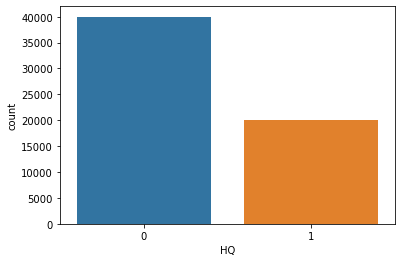

In [5]:
sns.countplot(x='HQ',data=df2)

In [6]:
df['text'] = df['Title'] + ' ' + df['Body']
df = df.drop(['Id', 'Title', 'CreationDate'], axis = 1)

df

,Body,Tags,Y,text
0,<p>I'm already familiar with repeating tasks e...,<java><repeat>,0,Java: Repeat Task Every Random Seconds <p>I'm ...
1,I am having 4 different tables like \r\nselect...,<sql><sql-server>,1,How to get all the child records from differen...
2,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2,Why are Java Optionals immutable? <p>I'd like ...
3,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2,Text Overlay Image with Darkened Opacity React...
4,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2,Why ternary operator in swift is so picky? <p>...
...,...,...,...,...
59995,<p>I try to multiply an integer by a double bu...,<c++>,0,C++ The correct way to multiply an integer and...
59996,<p>I'm very new to programming and I'm teachin...,<c#><visual-studio>,0,How can I make a c# application outside of vis...
59997,*URLS.PY*\r\n //URLS.PY FILE\r\n fro...,<django><django-views><django-templates>,1,WHY DJANGO IS SHOWING ME THIS ERROR WHEN I TRY...
59998,<p>I have a controller inside which a server i...,<javascript><php><html>,0,PHP - getting the content of php page <p>I hav...


In [7]:
nlp = spacy.load('en', disable=['ner', 'parser'])

def cleaning(doc):
    #remove stopwords + Lemmitze them 
    txt = [token.lemma_ for token in doc if not token.is_stop]
    
    if len(txt)>2:
        return ' '.join(txt)

In [9]:
init_cleaning = (re.sub("[^A-Za-z]+",' ',str(row)).lower() for row in df['text'])

In [12]:
t = time()

txt = [cleaning(doc) for doc in nlp.pipe(init_cleaning,batch_size=5000,n_threads=-1)]

print('Time too clean up everything: {} mins'.format(round((time() - t)/60,2)))

KeyboardInterrupt: 

In [ ]:
df_clean = pd.DataFrame({'clean':txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

In [10]:
from sklearn.model_selection import train_test_split
X=df['text'].values
y=df['Y'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True)
X_train

array(['Making a simple page responsive through CSS <p>I am using a simple half bootstrap / half designed by somebody login template. Now it opens just as it should through the web browser:</p>\n\n<p><a href="https://i.stack.imgur.com/lKZNP.jpg" rel="nofollow noreferrer"><img src="https://i.stack.imgur.com/lKZNP.jpg" alt="enter image description here"></a></p>\n\n<p>But when I open it through my mobile device it loads this way:</p>\n\n<p><a href="https://i.stack.imgur.com/Jhvsl.png" rel="nofollow noreferrer"><img src="https://i.stack.imgur.com/Jhvsl.png" alt="enter image description here"></a></p>\n\n<p>And I want it to open in a close-up way like that:</p>\n\n<p><a href="https://i.stack.imgur.com/D0YbC.png" rel="nofollow noreferrer"><img src="https://i.stack.imgur.com/D0YbC.png" alt="enter image description here"></a></p>\n\n<p>Now here are my html and css:</p>\n\n<p><div class="snippet" data-lang="js" data-hide="false" data-console="false" data-babel="false">\r\n<div class="snippet-c

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
#Vectorization
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
X_test

<12000x212002 sparse matrix of type '<class 'numpy.float64'>'
	with 757664 stored elements in Compressed Sparse Row format>

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
model = Sequential()
model.add(Dense(units=8270,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=4000,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1000,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=400,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model.fit(x=X_train,y=y_train,epochs=40,validation_data=(X_test, y_test), verbose=1,callbacks=[early_stop])

ValueError: Please provide as model inputs either a single array or a list of arrays. You passed: inputs=  (0, 189358)	0.05785868475958091
  (0, 324463)	0.060827333396160414
  (0, 55406)	0.07219124646941658
  (0, 226446)	0.05622473263721933
  (0, 297840)	0.033507710493137506
  (0, 308645)	0.06803926579987427
  (0, 321721)	0.10529317833341381
  (0, 36652)	0.12442725559185154
  (0, 435763)	0.0404007212620033
  (0, 448244)	0.03632213895997637
  (0, 336794)	0.06771180037217676
  (0, 55497)	0.12381361506802752
  (0, 318121)	0.12442725559185154
  (0, 431253)	0.12442725559185154
  (0, 55628)	0.12442725559185154
  (0, 401890)	0.12442725559185154
  (0, 260861)	0.07367474126231686
  (0, 397321)	0.07166910623223174
  (0, 374470)	0.06417339535946695
  (0, 435130)	0.03609687183380289
  (0, 99434)	0.021735418779530898
  (0, 42337)	0.12442725559185154
  (0, 284956)	0.02973333849358954
  (0, 42336)	0.12442725559185154
  (0, 53773)	0.053125400369478264
  :	:
  (47999, 321830)	0.17997184512103825
  (47999, 254391)	0.17338936063252694
  (47999, 242752)	0.1574661820045265
  (47999, 344564)	0.3192679692342787
  (47999, 276411)	0.31110808917151955
  (47999, 263266)	0.3467787212650539
  (47999, 242766)	0.2851814956412658
  (47999, 263404)	0.1538435793788888
  (47999, 182472)	0.0759198307033088
  (47999, 367321)	0.19567017356291108
  (47999, 325060)	0.0561471581645035
  (47999, 263245)	0.08543816388333926
  (47999, 225600)	0.06894571264637162
  (47999, 43331)	0.0631866412455483
  (47999, 50710)	0.05813358144678109
  (47999, 189239)	0.04608314055696306
  (47999, 455670)	0.03840566377028035
  (47999, 384504)	0.06706742613200724
  (47999, 445947)	0.03729674158319997
  (47999, 324463)	0.08798078341459817
  (47999, 99434)	0.03143815560042629
  (47999, 284956)	0.08601272711266224
  (47999, 317567)	0.03137185573210078
  (47999, 436925)	0.05809342486767915
  (47999, 36443)	0.05914265482254197